In [ ]:
#Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e
.g. pd.read_csv)

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Images_Flickr/3139876823_859c7d7c23.jpg
/content/drive/MyDrive/Images_Flickr/3142055158_01b9e4caa4.jpg
/content/drive/MyDrive/Images_Flickr/3136404885_f4d8f1d15a.jpg
/content/drive/MyDrive/Images_Flickr/3141440149_00becbbb93.jpg
/content/drive/MyDrive/Images_Flickr/3139238055_2817a0c7d8.jpg
/content/drive/MyDrive/Images_Flickr/3139118874_599b30b116.jpg
/content/drive/MyDrive/Images_Flickr/3138746531_f6b816c126.jpg
/content/drive/MyDrive/Images_Flickr/3136043366_b3f8607a0e.jpg
/content/drive/MyDrive/Images_Flickr/3136674757_57406c305c.jpg
/content/drive/MyDrive/Images_Flickr/3139160252_75109e9e05.jpg
/content/drive/MyDrive/Images_Flickr/3143978284_ac086be9a3.jpg
/content/drive/MyDrive/Images_Flickr/3143982558_9e2d44c155.jpg
/content/drive/MyDrive/Images_Flickr/3143991972_7193381aeb.jpg
/content/drive/MyDrive/Images_Flickr/3148286846_40ae914172.jpg
/content/drive/MyDrive/Images_Flickr/3143765063_a7761b16d3.jpg
/con

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
img_path = '/content/drive/MyDrive/Images_Flickr/'

In [ ]:
text_path = '/content/drive/MyDrive/Flickr_TextData'

In [ ]:
# load vgg19 model
model = VGG19()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# extract features from image
features = {}
directory = os.path.join(img_path)

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join('/content/drive/MyDrive/Flickr_TextData/features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join('/content/drive/MyDrive/Flickr_TextData/features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join('/content/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)


In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

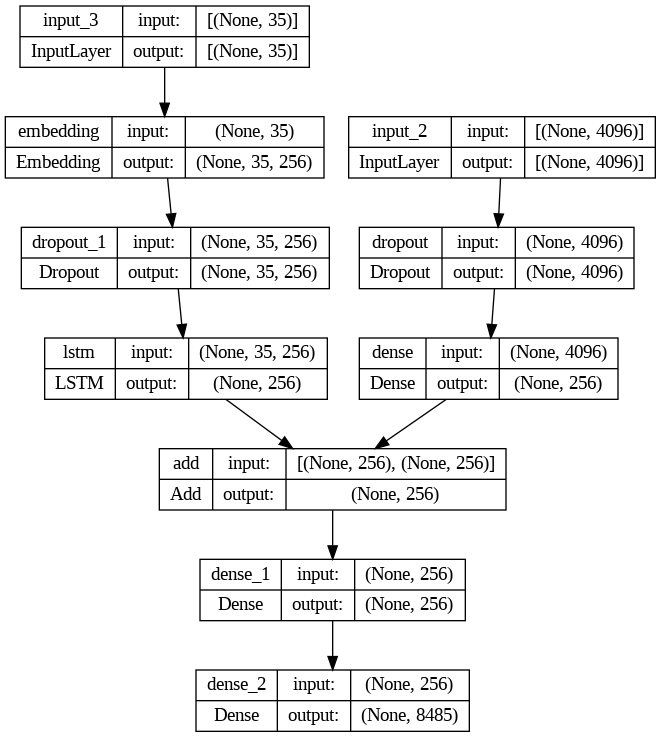

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 72s 317ms/step - loss: 2.1612


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.530349
BLEU-2: 0.303730


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/drive/MyDrive/Images_Flickr/', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq girl in pigtails splashes in the shallow water endseq
startseq girls plays in the surf endseq
startseq girl with pigtails is playing in the ocean by the beach endseq
startseq girl with pigtails plays in the water endseq
startseq young girl in pigtails plays in the water endseq
--------------------Predicted--------------------
startseq girl in pigtails plays in the water endseq


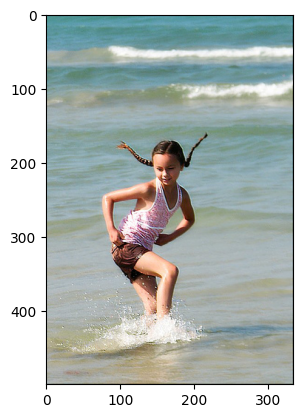

In [ ]:
generate_caption("1053804096_ad278b25f1.jpg")

Visualizations


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.plot(generator.history['loss'], label='Training Loss')
plt.plot(generator.generator['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


AttributeError: ignored

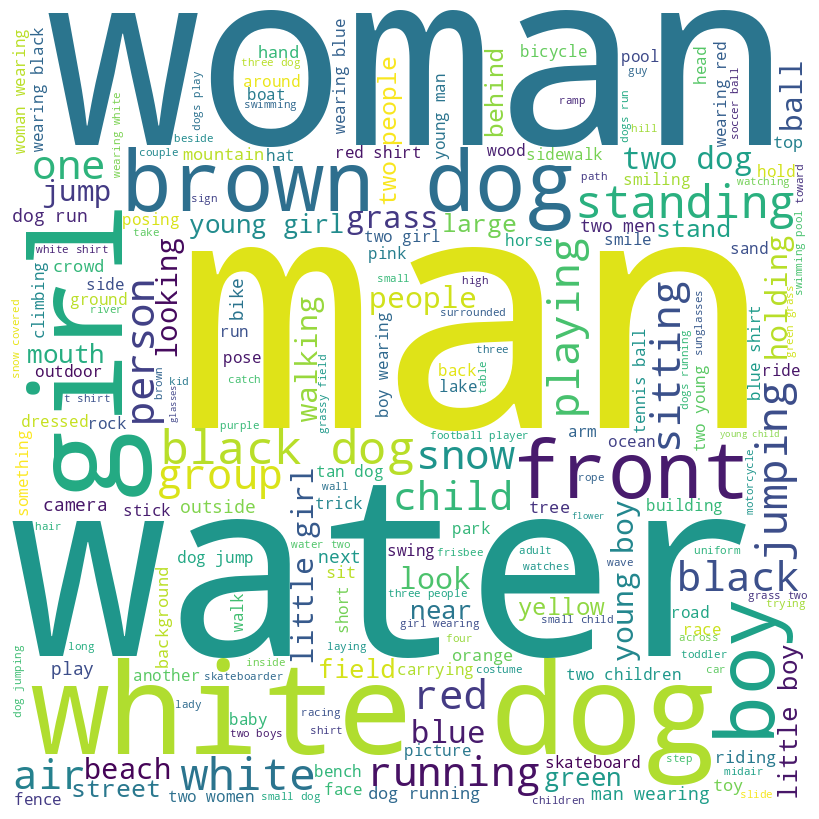

In [ ]:
from wordcloud import WordCloud

# Filter out "startseq" and "endseq" words from all_captions
filtered_captions = [caption.replace('startseq', '').replace('endseq', '') for caption in all_captions]

# Generate word cloud
caption_text = ' '.join(filtered_captions)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(caption_text)

# Plot word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


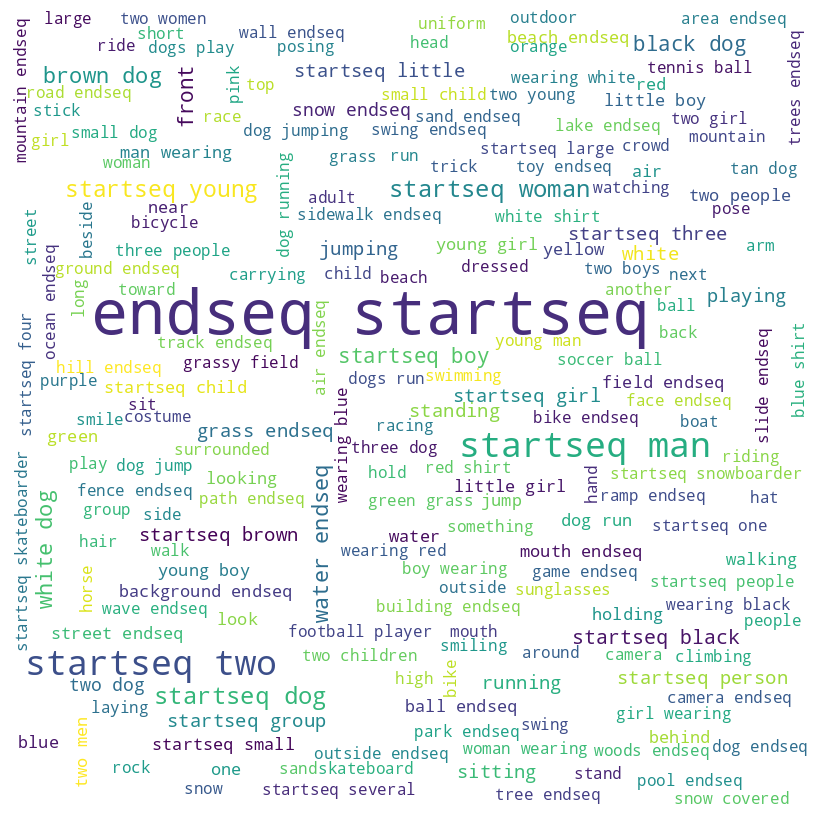

In [ ]:
from wordcloud import WordCloud

# Generate word cloud
caption_text = ' '.join(all_captions)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(caption_text)

# Plot word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [ ]:
# Generate captions for some test images
for idx in range(5):
    img_path = test_images[idx]
    img = load_image(img_path)
    caption = generate_caption(img, model, tokenizer)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()


In [ ]:
import numpy as np
import cv2

# Generate attention map for a given image and caption
img_path = 'path/to/image.jpg'
img = load_image(img_path)
caption = 'a man is riding a bicycle on a street'
att_map = generate_attention_map(img, caption, model, tokenizer)

# Resize attention map to match image size
att_map = cv2.resize(att_map, (img.shape[1], img.shape[0]))

# Overlay attention map on image
heatmap = cv2.applyColorMap(np.uint8(255*att_map), cv2.COLORMAP_JET)
overlayed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

# Plot original image and overlayed image with attention map
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(overlayed_img)
plt.title('Attention Map')
plt.axis('off')
plt.show()


In [ ]:
from sklearn.manifold import TSNE

# Generate embeddings for some test images
embeddings = []
for img_path in test_images:
    img = load_image(img_path)
    embedding = generate_embedding(img, model)
    embeddings.append(embedding)
embeddings = np.array(embeddings)

# Visualize embeddings using T-SNE
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title('T-SNE Visualization of Image Embeddings')
plt.show()
